In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as nnf
import torchvision
from torchvision import datasets, models, transforms

import os
import numpy as np
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torch.autograd import Variable

import cv2
import imutils

import math

BCK_COLOR = (255, 255, 255) # (255, 255, 255) WHITE

In [16]:
model_load_path = 'models/ptah.pth'
num_channels = 3

data_dir = 'data' 
template_dir = '../template_images'

trained_signs = np.load('class_names.npy')
trained_signs.sort()

num_signs = len(trained_signs)

print('Signs in the trained model:',trained_signs)

Signs in the trained model: ['A1' 'A21' 'A30' 'A40' 'AA1' 'D21' 'D28' 'D35' 'D36' 'D37' 'D46' 'D58'
 'F31' 'F32' 'F35' 'G1' 'G17' 'G26' 'G36' 'G36A' 'G38' 'G39' 'G43' 'H6'
 'I10' 'I9' 'L1' 'M17' 'M40' 'M5' 'N16' 'N17' 'N29' 'N35' 'N37' 'O4' 'Q3'
 'R11' 'R8' 'S29' 'S34' 'S40' 'T34' 'T35' 'U36' 'V13' 'V28' 'V30' 'V31'
 'W11' 'X1' 'X8' 'Y1' 'Y3' 'Y5' 'Z1' 'Z4']


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, num_signs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))   
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# OCR test dataset
data_transforms = {
'train': transforms.Compose([
    transforms.Resize([32, 32]),        
    transforms.Grayscale(num_channels),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),    
'ocr': transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.Grayscale(num_channels),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),    
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                    data_transforms[x])
            for x in ['ocr']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                        shuffle=True, num_workers=4)
            for x in ['ocr']}

ocr_classes = image_datasets['ocr'].classes

print('Signs in the OCR Dataset:',ocr_classes)

Signs in the OCR Dataset: ['AA1', 'D21', 'D36', 'D46', 'D58', 'F32', 'G1', 'G17', 'G43', 'I10', 'I9', 'M17', 'N29', 'N35', 'N37', 'O4', 'Q3', 'S29', 'V13', 'V28', 'V31', 'W11', 'X1']


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_load_path))
else:
    model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

if torch.cuda.is_available():  
    model.cuda()

model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=57, bias=True)
)

# 1. Detection and Classification demo
## Take 1 register (row) of hieroglyphs and detect and classify

In [19]:
#
# Auxiliary functions 
#

def get_sign_from_image(img):
    model = Net()
    model.load_state_dict(torch.load(model_load_path))
    model.eval()

    with torch.no_grad():
        img_tensor = data_transforms['ocr'](img)
        img_tensor.unsqueeze_(0)

        outputs = model(img_tensor)
        _, preds = torch.max(outputs,1)      

    return trained_signs[preds[0]]

def get_bounding_boxes(im,width,height,reverse=False,j=0):

    bg = Image.new(mode = "RGB", size = (width,height), color = BCK_COLOR )
    bg = cv2.cvtColor(np.asarray(bg), cv2.COLOR_RGB2BGR)

    img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

    diff = cv2.absdiff(bg, img)

    #converting the difference into grascale
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    #increasing the size of differences so we can capture them all
    for i in range(0, 3):
        dilated = cv2.dilate(gray.copy(), None, iterations= i+ 1)

    (T, thresh) = cv2.threshold(dilated, 3, 255, cv2.THRESH_BINARY)
    
    # now we need to find contours in the binarised image
    cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if cnts == []:
        return [],[]

    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][j], reverse=reverse))    

    return cnts, boundingBoxes

def non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = np.fromiter((x[0] for x in boxes),np.int)
    y1 = np.fromiter((x[1] for x in boxes),np.int)
    x2 = np.fromiter((x[2] for x in boxes),np.int)
    y2 = np.fromiter((x[3] for x in boxes),np.int)
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

	# keep looping while some indexes still remain in the indexes
	# list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    return pick

def print_output(output,base_image,print_order=False):

    for i,ocr in enumerate(output):
        sign = ocr[0]
        x, y, w, h = ocr[1]

        ocr_cropped = base_image.crop((x, y, x + w, y + h))

        # print_sign(sign,ocr_cropped)

        overlay_data(base_image,sign,ocr[1],i,print_order)

def print_sign(sign,ocr_img):
    template_dir = 'fonts-data/'

    filename = sign+'_AbydosB_200_crop.jpg'
    template_file = os.path.join(template_dir,filename)
    template_img = Image.open(template_file)

    fig, axs = plt.subplots(1,2)
    axs[0].imshow(ocr_img)
    axs[0].set_title('Extracted sign')
    axs[1].imshow(template_img)
    axs[1].set_title('Predicted sign:'+sign)
    plt.show(block=True)

def overlay_data(img,sign,boundingbox,order,print_order=False):
    x, y, w, h = boundingbox
    if print_order:
        text = str(order)+'-'+sign
    else: 
        text = str(sign)

    draw = ImageDraw.Draw(img)
    draw.text((x, y-5), text, (255, 0, 0))    

In [20]:
def ocr_image_level_1(base_filename):
    output = []

    txt = cv2.imread(base_filename,0)

    original_h,original_w = txt.shape
    txt_gray = cv2.cvtColor(txt, cv2.COLOR_BGR2RGB)

    base_image = txt_gray.copy()

    cnts, boundingBoxes = get_bounding_boxes(txt_gray,original_w,original_h)

    img = cv2.cvtColor(np.array(txt), cv2.COLOR_RGB2BGR)

    boundingBoxes_sup = np.asarray(boundingBoxes)
    boundingBoxes_sup[:,2] += boundingBoxes_sup[:,0]
    boundingBoxes_sup[:,3] += boundingBoxes_sup[:,1]
    boundingBoxes_sup = boundingBoxes_sup.tolist()

    # Supress non-maxima
    pick = non_max_suppression(boundingBoxes_sup,0.3)
    pick.sort()

    # print(pick)
    
    # Iterate bounding boxes
    for idx_sign,sign in enumerate(pick):
        
        # if idx_sign in range(1,2):
            (x, y, w, h) = boundingBoxes[sign]               

            img_cropped = Image.fromarray(txt_gray).crop((x, y, x + w, y + h))

            original_size = (img_cropped.width,img_cropped.height)
            img_cropped2 = img_cropped.resize((img_cropped.width*10,img_cropped.height*10))  
       

            # go down 1 level to check if needed
            cnts1, boundingBoxes1 = get_bounding_boxes(img_cropped2,img_cropped2.width,img_cropped2.height)
            
            boundingBoxes1_sup = np.asarray(boundingBoxes1)
            boundingBoxes1_sup[:,2] += boundingBoxes1_sup[:,0]
            boundingBoxes1_sup[:,3] += boundingBoxes1_sup[:,1]
            boundingBoxes1_sup = boundingBoxes1_sup.tolist()

            pick1 = non_max_suppression(boundingBoxes1_sup,0.3)
            pick1.sort()
            
            if len(pick1) > 1:
                for idx_sign1,sign1 in enumerate(pick1):
                    (x1, y1, w1, h1) = boundingBoxes1[sign1]                

                    cv2.rectangle(base_image, (x+int(x1/10), y+int(y1/10)), (x+int(x1/10)+int(w1/10), y+int(y1/10)+int(h1/10)), (0, 255, 0), 1)
    
                    img_cropped3 = img_cropped2.crop((x1, y1, x1+w1,y1+h1))
                    ocr_sign = get_sign_from_image(img_cropped3)

                    output.append([ocr_sign,(x+int(x1/10), y+int(y1/10), int(w1/10), int(h1/10))])
            else:
                ocr_sign = get_sign_from_image(img_cropped)
                cv2.rectangle(base_image, (x, y), (x + w, y + h), (0, 0, 255), 1)
                output.append([ocr_sign,boundingBoxes[sign]])  
                # output.append([ocr_sign,(x, y, x + w, y + h)])

    Image.fromarray(base_image).save(os.path.splitext(base_filename)[0]+'_out.png')
    
    return output

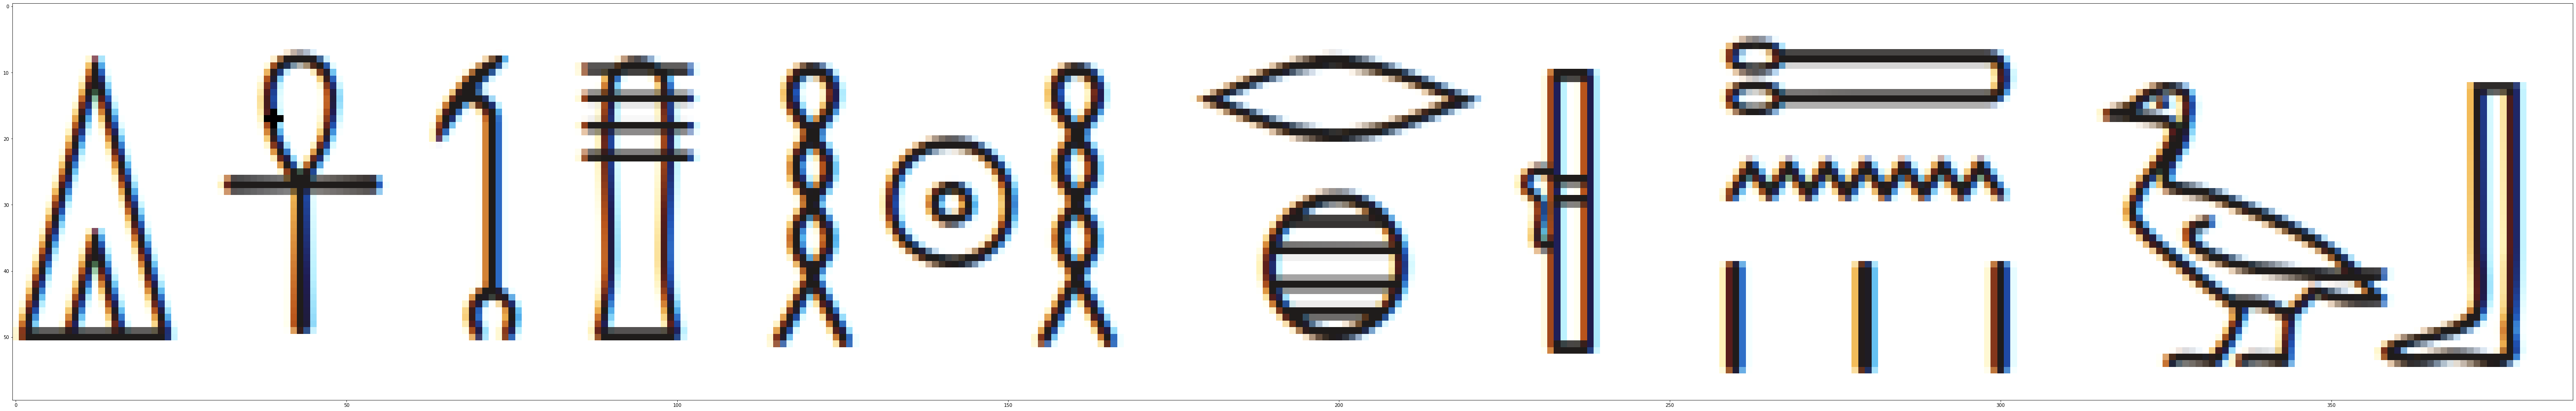

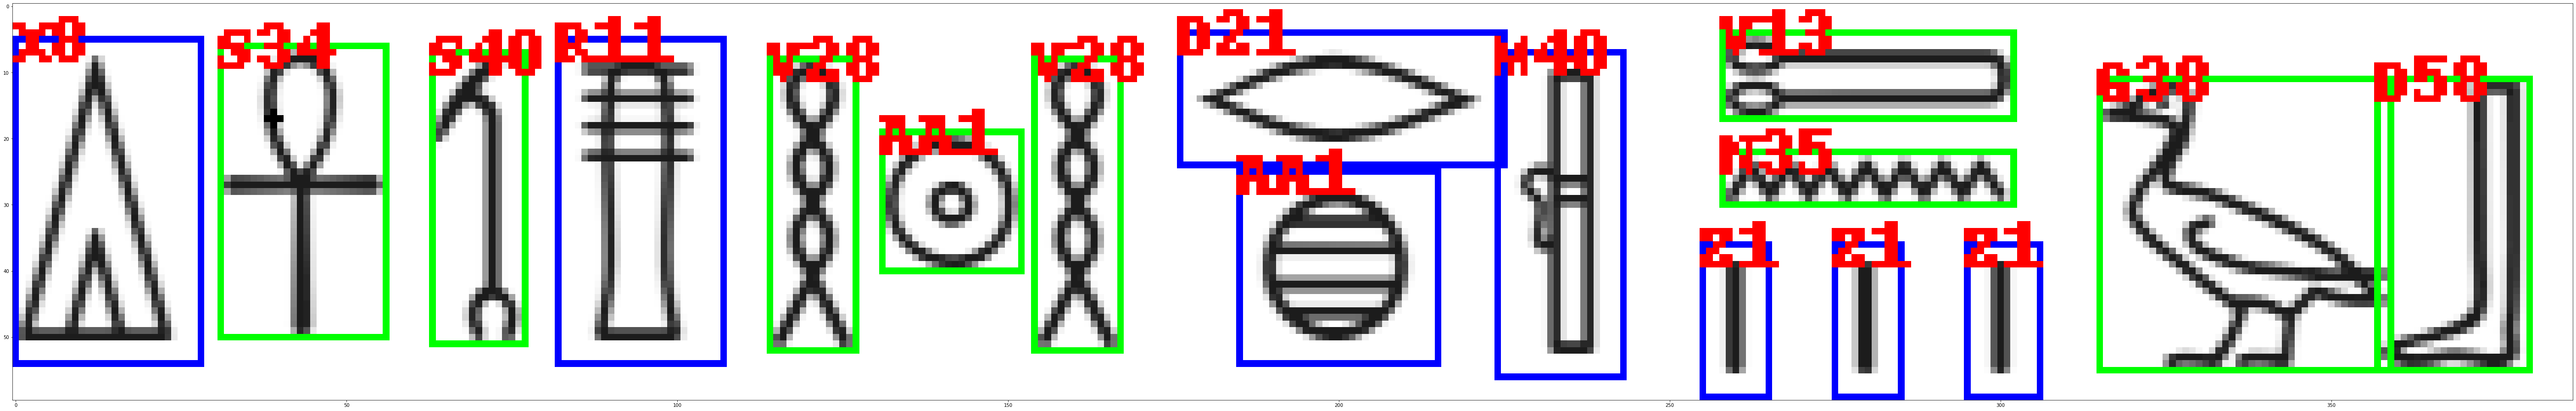

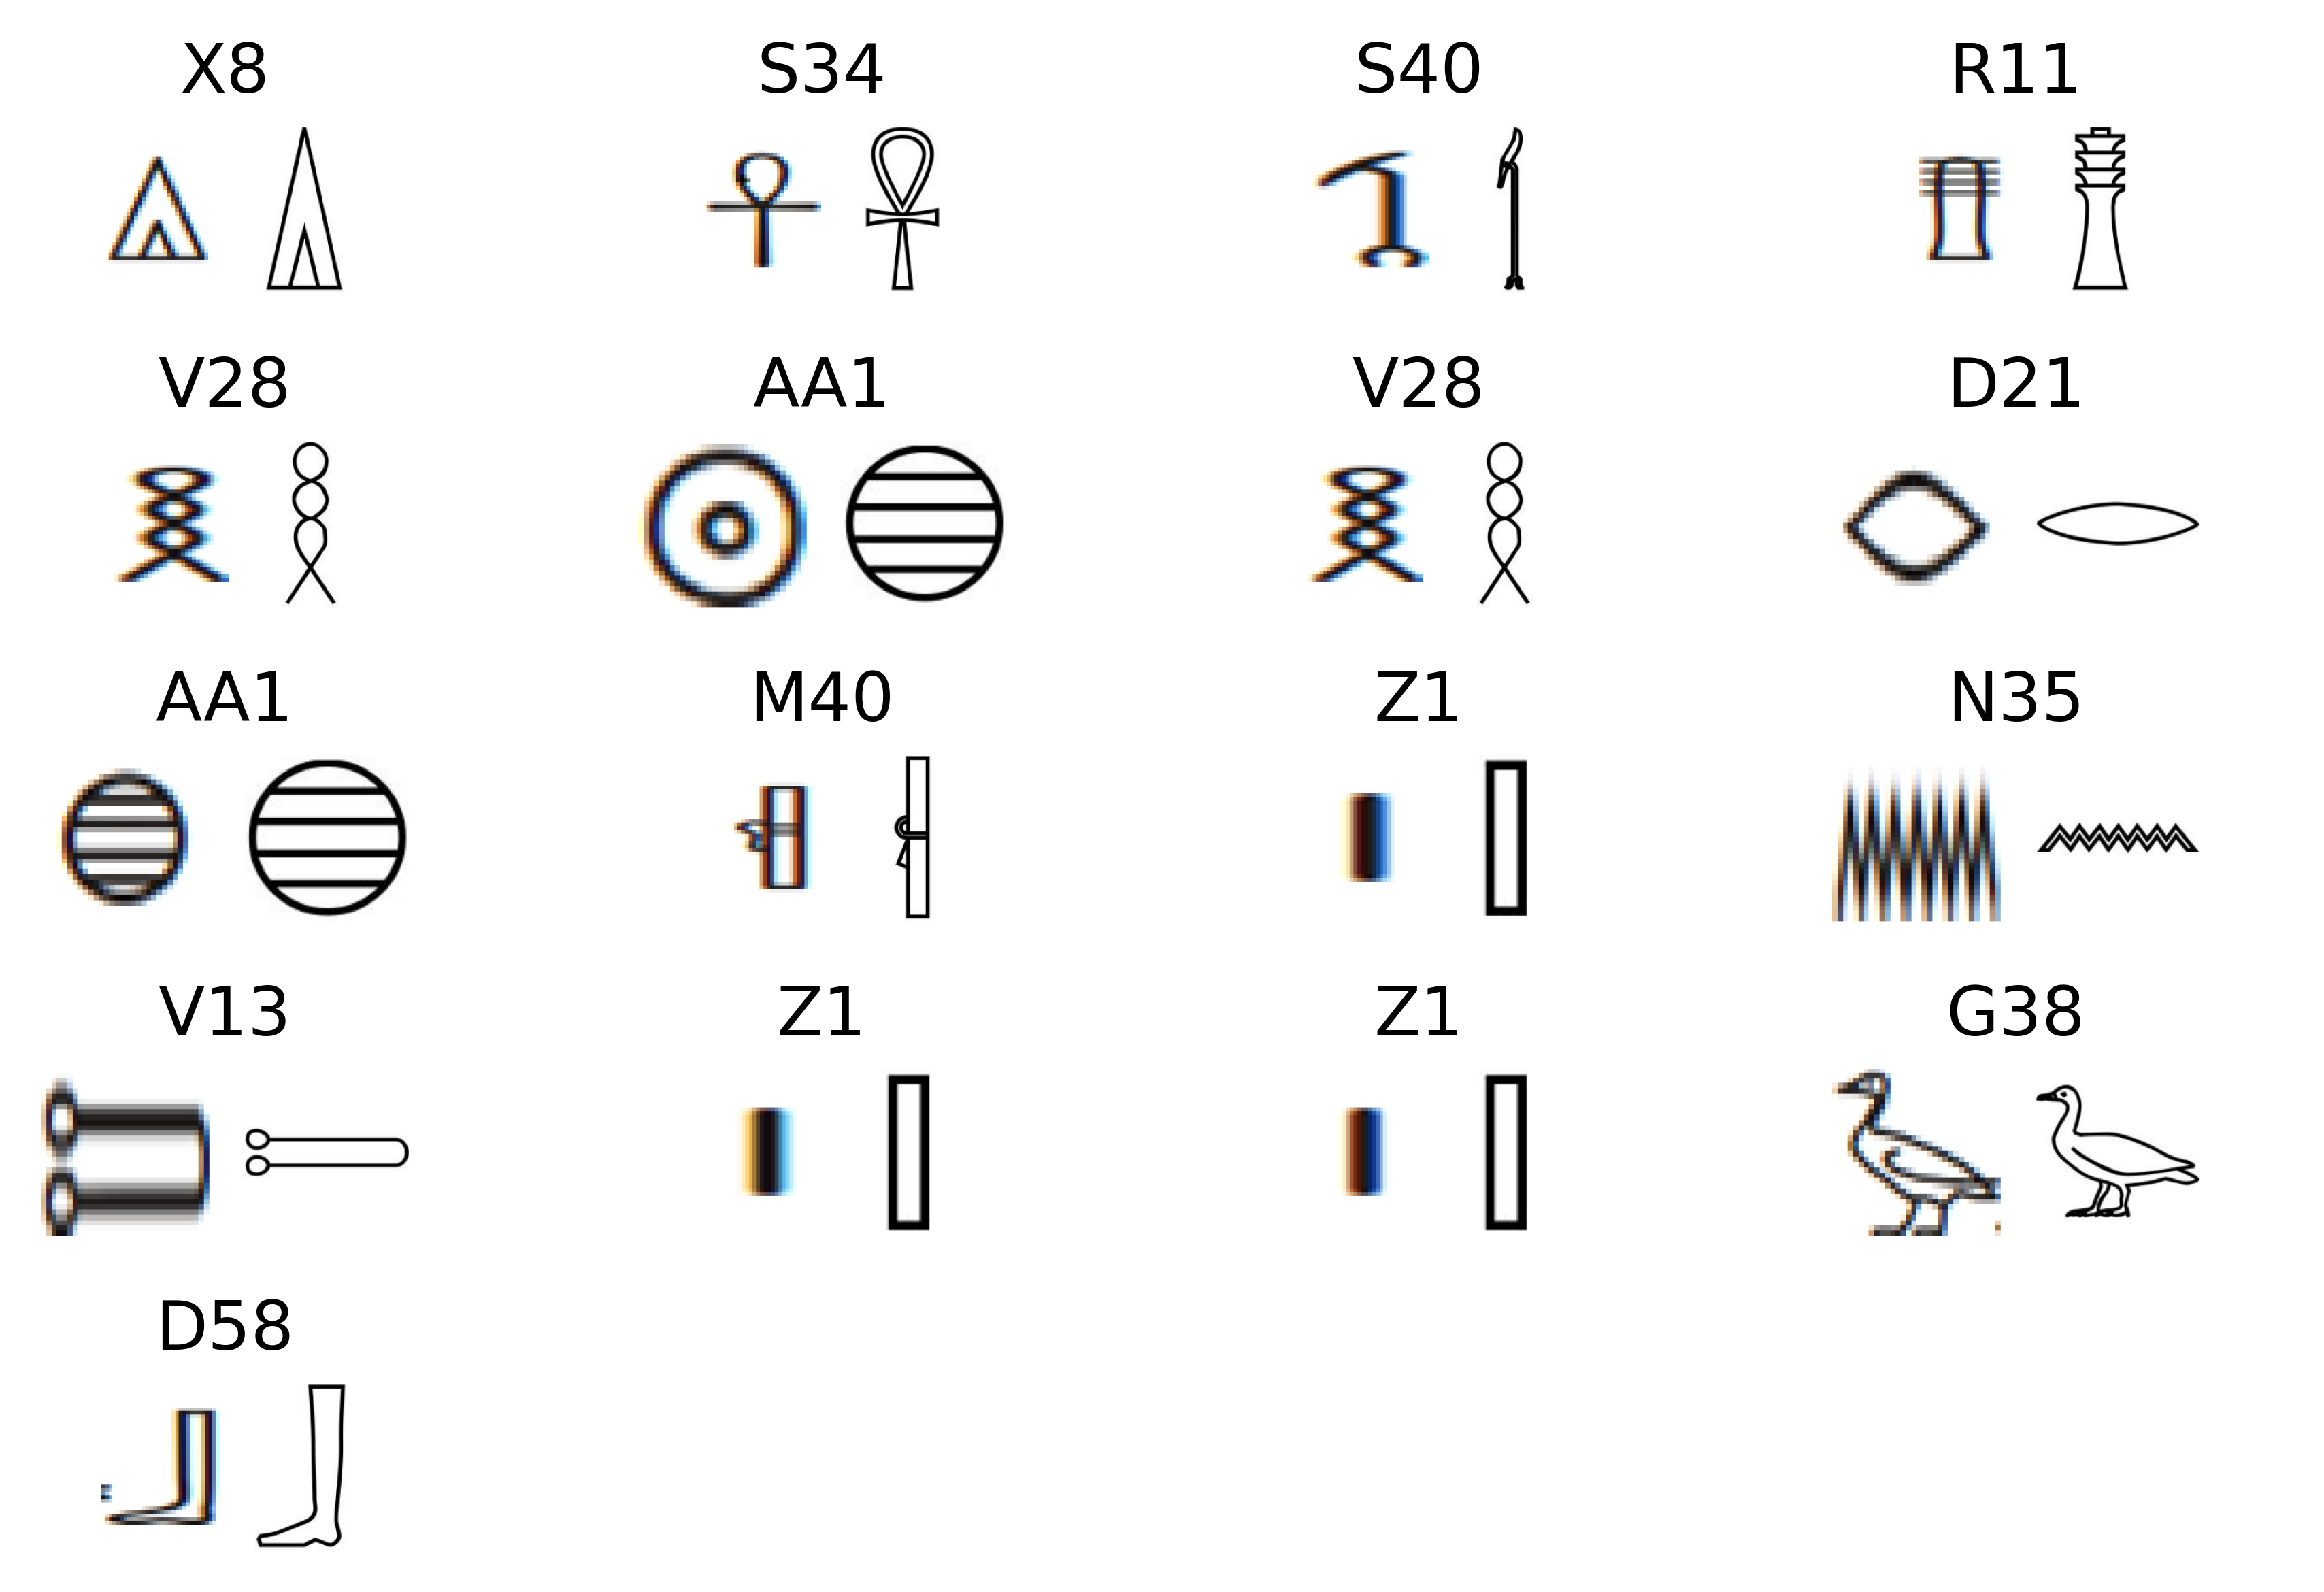

In [21]:
output =[]
base_filename  = 'row.png'
test_dir = 'test-images'

show_order = False
show_bounding_boxes = True
show_detailed_results = True

base_image = Image.open(os.path.join(data_dir,test_dir,base_filename))

plt.figure(figsize=(100,100))
plt.imshow(base_image, cmap='binary')
plt.show()

output = ocr_image_level_1(os.path.join(data_dir,test_dir,base_filename))

if show_bounding_boxes:
    out_filename = os.path.splitext(base_filename)[0]+'_out.png'
else:
    out_filename = os.path.splitext(base_filename)[0]+'.png'

out_image = Image.open(os.path.join(data_dir,test_dir,out_filename))

print_output(output,out_image,show_order)

plt.figure(figsize=(100,100))
plt.imshow(out_image, cmap='binary')
plt.show()

idx = 0
lout = len(output)
if show_detailed_results:
    num_rows = math.ceil(len(output)/4)

    output_images = list()

    for i in range(0,num_rows):
        for j in range(0,4):


            if idx < lout:
                pred_sign = output[idx][0]
                x, y, w, h = output[idx][1]

                ocr_cropped = base_image.crop((x, y, x + w, y + h)).resize((32,32))

                template_filename = pred_sign+'_AbydosB_200_crop.jpg'
                template_file = os.path.join(template_dir,template_filename)
                template_img = Image.open(template_file)

                figtmp,axstmp = plt.subplots(1,2)
                axstmp[0].axis('off') 
                axstmp[1].axis('off') 
                axstmp[0].imshow(ocr_cropped)
                axstmp[1].imshow(template_img)

                mng = plt.get_current_fig_manager()
                mng.full_screen_toggle()
                plt.axis("off")
                plt.close()

                canvas = mng.canvas
                canvas.draw()

                bbox1  = canvas.figure.get_tightbbox(canvas.get_renderer())

                pil_image = Image.frombytes('RGB', canvas.get_width_height(), 
                    canvas.tostring_rgb())
                
                pil_image = pil_image.crop((int(bbox1._bbox.x0),int(bbox1._bbox.y0),int(bbox1._bbox.x1),int(bbox1._bbox.y1)))

                plt.close()

                output_images.append(pil_image)
            idx += 1



    idx = 0


    fig,axs = plt.subplots(num_rows,4, dpi=600)
    fig.patch.set_visible(False)
    # axs.axis('off')    
    plt.axis("off")
    for i in range(0,num_rows):
        for j in range(0,4):
            axs[i,j].axis('off') 

            if idx < lout:
                pred_sign = output[idx][0]              
                axs[i,j].imshow(output_images[idx])
                axs[i,j].set_title(pred_sign)
            idx+=1  
    plt.tight_layout()       
 

# 2. Detection and Classification demo (advanced)
## Take a full text (multiple registers aka rows) of hieroglyphs and detect and classify

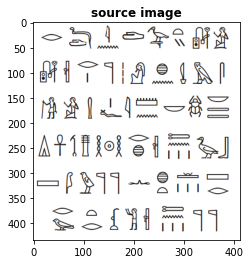

number_rows:  6


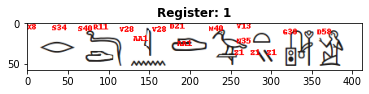

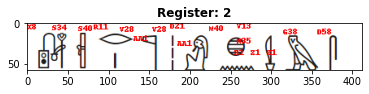

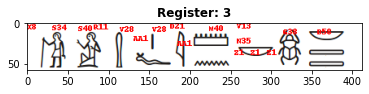

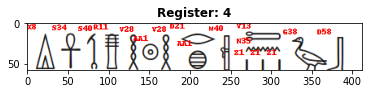

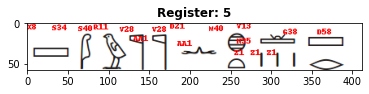

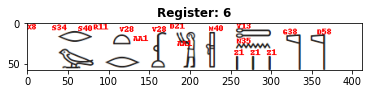

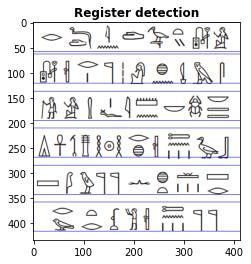

In [22]:
base_filename  = 'text.png'

# print(os.path.join(data_dir,test_dir,base_filename))

base_image = Image.open(os.path.join(data_dir,test_dir,base_filename))

plt.title('source image',fontweight ="bold")
plt.imshow(base_image, cmap='binary',)
plt.show()

draw = ImageDraw.Draw(base_image)

num_ocr_signs = len(output)

sum_heights,max_height,max_width = 0,0,0
# max_height = 0
# max_width = 0

min_x_location = 1000000
max_x_location = 0

min_y_location = 1000000
max_y_location = 0

for i in output:
    y_location = i[1][1]
    x_location = i[1][0]
    width = i[1][2]

    # print(i[0],i[1])
    sum_heights += i[1][3]

    if width > max_width:
        max_width = width

    if i[1][3] > max_height:
        max_height = i[1][3]

    if x_location < min_x_location:
        min_x_location = x_location

    if x_location > max_x_location:
        max_x_location = x_location

    if y_location < min_y_location:
        min_y_location = y_location

    if y_location > max_y_location:
        max_y_location = y_location


number_rows = base_image.height / (max_height*1.5)

height_scaling = 1.2

base_image = Image.open(os.path.join(data_dir,test_dir,base_filename))
draw = ImageDraw.Draw(base_image)

print('number_rows: ',round(number_rows))


for i in range (1,round(number_rows)+1):
    # print(i)
    x = min_x_location
    if i == 1:
        y = 0
    else:
        y = base_image.height/number_rows*(i-1)-10   #int(i*max_height)
    h = y + int(max_height*height_scaling)
    w = base_image.width 
    
    # print('(i:x,y,w,h):',(i,x,y,w,h))

    img_cropped = base_image.crop((x,y,w,h))

    print_output(output,img_cropped)

    # plt.figure(figsize=(100,100))
    plt.title('Register: '+str(i),fontweight ="bold")
    plt.imshow(img_cropped, cmap='binary')
    plt.show()    

    draw.rectangle([x,y,w,h],outline="blue")   

plt.title('Register detection',fontweight ="bold")
plt.imshow(base_image, cmap='binary')
plt.show()    
